#TUNED XGBOOST MODEL

I created this model to see if the results that it provides can provide useful insights, and to make predictions based on the data. A comparison is then made between the performance of the tuned decision tree, random forest and XGBoost models.

This model achieved high scores, showing that it is very good at predicting

| Model        |    F1    |	 Recall  | Precision| Accuracy|
|:-------------|:--------:|:--------:|:--------:|--------:|
|Tuned XGBoost | 0.982216 |	0.977778 | 0.987654 |	0.979167|

The confusion matrix and precision score indicates that this model is very good at correctly predicting life expectancy.

The model shows the following three features as being the most important in predicting life expectancy:

  1. Probability of dying from any of CVD, cancer, diabetes, CRD between age 30 and exact age 70 (%)_nan
  2. Under-five mortality rate (per 1000 live births)_SEX_BTSX
  3. Adolescent birth rate (per 1000 women)_AGEGROUP_YEARS15-19

For both the decision tree and XGBoost models, the top feature in terms of importance is "Probability of dying from any of CVD, cancer, diabetes, CRD between age 30 and exact age 70 (%)_nan."

This indicates that focusing on preventing cardiovascular diseas, cancer, diabetes and chronic respiratory disease would be most effective in improving life expectancy.

The comparison of the scores from the three models, random forest, decision tree and XGBoost, all tuned, shows that the random forest and XGBoost models performed very well.


|        Model       |     F1     |   Recall   | Precision | Accuracy|
|:-------------------|:----------:|:----------:|:---------:|--------:|
|Tuned Random Forest |  0.979004  |  0.979167  |  0.979938 | 0.979167|
|Tuned XGBoost       |  0.982216  |  0.977778  |  0.987654 | 0.979167|
|Tuned Decision Tree |  0.852610  |	 0.859259  |  0.870532 | 0.854167|





In [1]:
####################
# IMPORT LIBRARIES #
####################

# Import numpy`, pandas`, pickle`, and `sklearn
# Import the relevant functions from `sklearn.ensemble,
# `sklearn.model_selection`, and `sklearn.metrics`.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
import csv

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier, plot_importance

In [2]:
###############
# THE DATASET #
###############

# Import the data
WHO_data = pd.read_csv('web_download_data_WHO.csv')

# Display the first 10 rows of data
WHO_data.head(10)

# Display the data type for each column
WHO_data.dtypes


,0
IND_NAME,object
DIM_GEO_NAME,object
IND_CODE,object
DIM_GEO_CODE,object
DIM_TIME_YEAR,int64
DIM_1_CODE,object
VALUE_NUMERIC,float64
VALUE_STRING,object
VALUE_COMMENTS,object


In [3]:
################
# DATA SHAPING #
################

# Pivot dataframe to create columns based on IND_NAME
WHO_data_pivot = WHO_data.pivot(index=['DIM_GEO_NAME'],
                        columns=['IND_NAME','DIM_1_CODE'], values='VALUE_NUMERIC')

WHO_data = WHO_data_pivot.reset_index()

# Flatten multi-index pivot into dataframe
WHO_data.columns = WHO_data.columns.to_flat_index()
WHO_data.columns = ['_'.join(str(col) for col in multi_col) for multi_col in WHO_data.columns]

# Import CSV file as dictionary, used to rename long column names
def csv_to_dict_no_header(filename):
    """Imports a two-column CSV file into a dictionary.

    Args:
        filename (str): The filename of the CSV file.

    Returns:
        dict: A dictionary where the first column is the key and the second is the value.
    """
    data_dict = {}
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
           if row:  # Ensure the row is not empty
                key = row[0]
                value = row[1]
                data_dict[key] = value
    return data_dict

filename = 'WHO_data_1_columns_dict.csv'
data_as_dict = csv_to_dict_no_header(filename)

WHO_data.rename(columns=data_as_dict, inplace=True)

# Create 'Life_expectancy_category' column
condition1 = (WHO_data['Life_expect_at_brth_yrs_BTSX'] <= 65)
condition2 = ((WHO_data['Life_expect_at_brth_yrs_BTSX'] > 65)
  & (WHO_data['Life_expect_at_brth_yrs_BTSX'] <= 75))
condition3 = (WHO_data['Life_expect_at_brth_yrs_BTSX'] > 75)

value1 = 'Low'
value2 = 'Medium'
value3 = 'High'
defaultvalue = 'NaN'

WHO_data['Life_expectancy_category'] = np.select([condition1, condition2,
                                               condition3],
                                                [value1, value2, value3],
                                              default=defaultvalue)

WHO_data = WHO_data.fillna(0)

# Remove records with Life_expectancy_category == NaN
WHO_data = WHO_data[WHO_data['Life_expectancy_category'] != 'NaN']

# Drop column Life_expect_at_brth_yrs_BTSX, used in creating Life_expectancy_category
WHO_data = WHO_data.drop(columns=['Life_expect_at_brth_yrs_BTSX'])

# Drop columns with high correlation to target variable to remove impact on feature importance
WHO_data = WHO_data.drop(columns=['Life_expect_at_brth_yrs_MLE',
                       'Life_expect_at_brth_yrs_FMLE',
                       'Healthy_life_expect_at_birth_yrs_BTSX',
                       'Healthy_life_expect_at_birth_yrs_MLE',
                       'Healthy_life_expect_at_birth_yrs_FMLE'],
              )


In [4]:
#####################
# MODEL PREPARATION #
#####################

# Convert the object predictor variable to numerical dummies.
WHO_data_pred_dummies = pd.get_dummies(WHO_data, columns=['DIM_GEO_NAME_'], dtype=int)

# Convert the target variable using label encoding
label_encoder = LabelEncoder()
WHO_data_target_dummies = label_encoder.fit_transform(WHO_data['Life_expectancy_category'])

# Define the y (target) variable.
y = WHO_data_target_dummies

# Define the X (predictor) variables.
X = WHO_data_pred_dummies.drop(columns=['Life_expectancy_category'])

# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [5]:
##################
# MODEL BUILDING #
##################

%%time

# Define xgb to be the XGBClassifier.
xgb = XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)

# Define parameters for tuning as `cv_params`.
cv_params = {'max_depth': [4, 6],
'min_child_weight': [3, 5],
'learning_rate': [0.1, 0.2, 0.3],
'n_estimators': [5,10,15],
'subsample': [0.7],
'colsample_bytree': [0.7]
}

# Define how the models will be evaluated
# Define the criteria as `scoring
scoring = {'accuracy': 'accuracy',
             'precision': 'precision_macro',
             'recall': 'recall_macro',
             'f1': 'f1_macro'}


# Construct the GridSearch cross-validation
xgb_cv = GridSearchCV(xgb,
                        cv_params,
                        scoring = scoring,
                        cv = 5,
                        refit = 'f1')

# Fit the GridSearch model to training data
xgb_cv = xgb_cv.fit(X_train, y_train)
print('\nxgb_cv:')
display(xgb_cv)
print('\nBest params:')
display(xgb_cv.best_params_)
print(f'\nBest score: {xgb_cv.best_score_:.3f}\n')

# Use `pickle` to save the trained model.
pkl.dump(xgb_cv, open('xgb_cv.sav', 'wb'))



xgb_cv:


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_class=3, ...),
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.1, 0.2, 0.3], 'max_depth': [4, 6],
                         'min_child_weight': [3, 5],
                         'n_estimators': [5, 10, 15], 'subsample': [0.7]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1_macro',
                      'precision': 'precision_macro',
                      'recall': 'recall_macro'})


Best params:


{'colsample_bytree': 0.7,
 'learning_rate': 0.2,
 'max_depth': 4,
 'min_child_weight': 3,
 'n_estimators': 15,
 'subsample': 0.7}


Best score: 0.832

CPU times: user 34.9 s, sys: 198 ms, total: 35.1 s
Wall time: 29.2 s


accuracy score: 0.979
precision score: 0.988
recall score: 0.978
f1 score: 0.982

Labels and label names:
[0 1 2]
['High' 'Low' 'Medium']


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

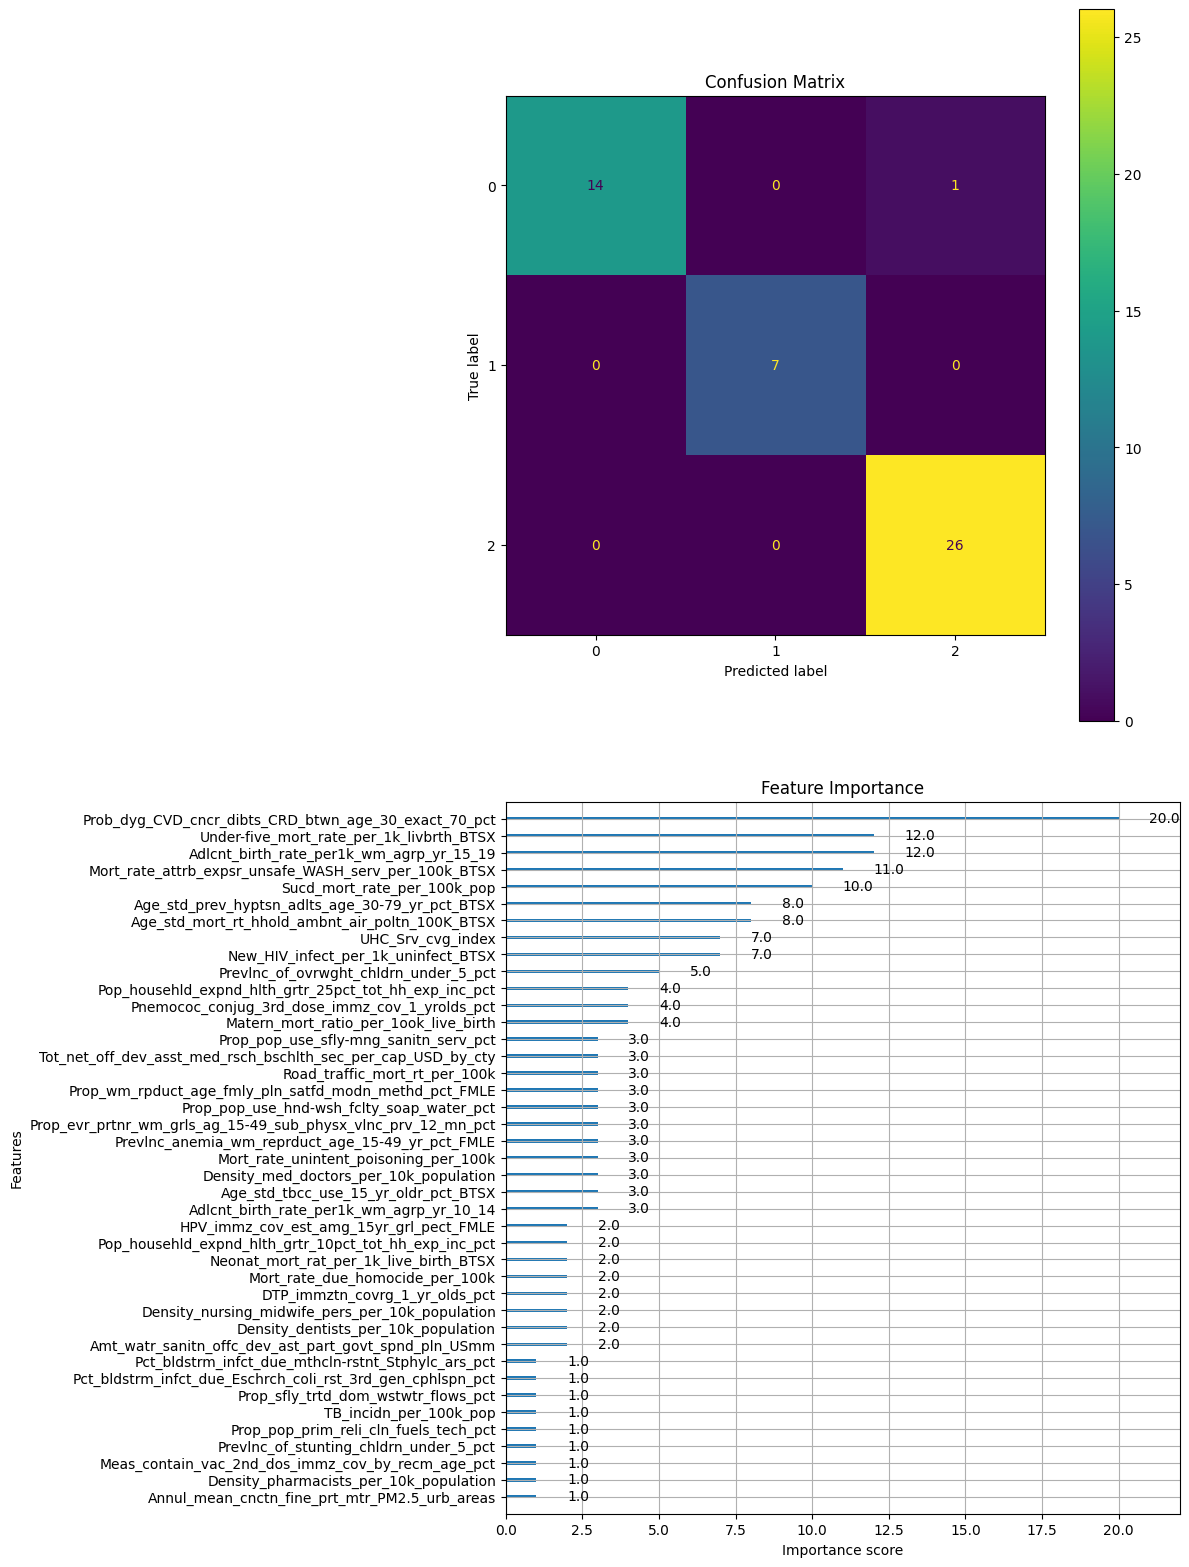

,Model,F1,Recall,Precision,Accuracy
0,Tuned Random Forest,0.979004,0.979167,0.979938,0.979167
1,Tuned XGBoost,0.982216,0.977778,0.987654,0.979167
2,Tuned Decision Tree,0.852610,0.859259,0.870532,0.854167


In [6]:
##########################
# RESULTS AND EVALUATION #
##########################

# Formulate predictions based on the test set
# Apply the model to predict on the test data (set output as "y_pred").
y_pred = xgb_cv.predict(X_test)

# Leverage metrics to evaluate the model's performance
# 1. Print the accuracy score.
ac_score = metrics.accuracy_score(y_test, y_pred)
print(f'accuracy score: {ac_score:.3f}')

# 2. Print the precision score.
pc_score = metrics.precision_score(y_test, y_pred, average='macro')
print(f'precision score: {pc_score:.3f}')

# 3. Print your recall score.
rc_score = metrics.recall_score(y_test, y_pred, average='macro')
print(f'recall score: {rc_score:.3f}')

#4. Print your f1 score.
f1_score = metrics.f1_score(y_test, y_pred, average='macro')
print(f'f1 score: {f1_score:.3f}\n')

# Create a figure with two subplots
# (one for the confusion matrix and one for the feature importance)
fig, axes = plt.subplots(2, 1, figsize=(12, 16))

# Construct the confusion matrix for the predicted and test values.
cm = metrics.confusion_matrix(y_test, y_pred)

# Create the display for your confusion matrix.
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=xgb_cv.classes_)

labels = xgb_cv.classes_
label_names = label_encoder.inverse_transform(xgb_cv.classes_)
print(f'Labels and label names:\n{labels}\n{label_names}')

# Plot the visual in-line.
display(disp.plot(ax=axes[0]))
axes[0].set_title('Confusion Matrix')

# Plot the relative feature importance of the predictor variables in your model.
display(plot_importance(xgb_cv.best_estimator_, ax=axes[1]))
axes[1].set_title('Feature Importance')

plt.tight_layout()
plt.show()
print('\n')

# Create a table of results to compare model performance.
table = pd.DataFrame({'Model': ['Tuned Random Forest','Tuned XGBoost','Tuned Decision Tree'],
                      'F1': [0.979004, f1_score, 0.85261],
                      'Recall': [0.979167, rc_score, 0.859259],
                      'Precision': [0.979938, pc_score, 0.870532],
                      'Accuracy': [0.979167, ac_score, 0.854167]
                      }
                     )
table